In [ ]:
# default_exp funcs.train_sl

In [ ]:
%load_ext autoreload
%autoreload 2

# Training loop simulator learning

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
import shutil
from torch.utils.tensorboard import SummaryWriter
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian
# from decode_fish.funcs.visualization import get_simulation_statistics

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
#export
def eval_logger(writer, pred_df, target_df, iteration, data_str='Sim. '):
    
    perf_dict,_,shift = matching(target_df, pred_df, print_res=False)
    if 'Inp' in data_str:
        pred_corr = shift_df(pred_df, shift)
        perf_dict, _, _ = matching(target_df, pred_corr, print_res=False)

    writer.add_scalar(data_str +'Metrics/eff_3d', perf_dict['eff_3d'], iteration)
    writer.add_scalar(data_str +'Metrics/jaccard', perf_dict['jaccard'], iteration)
    writer.add_scalar(data_str +'Metrics/rmse_vol', perf_dict['rmse_vol'], iteration)

    writer.add_scalar(data_str +'Metrics/precision', perf_dict['precision'], iteration)
    writer.add_scalar(data_str +'Metrics/recall', perf_dict['recall'], iteration)
    writer.add_scalar(data_str +'Metrics/rmse_x', perf_dict['rmse_x'], iteration)
    writer.add_scalar(data_str +'Metrics/rmse_y', perf_dict['rmse_y'], iteration)
    writer.add_scalar(data_str +'Metrics/rmse_z', perf_dict['rmse_z'], iteration)   

def load_from_eval_dict(eval_dict):
    
    eval_img = load_tiff_image(eval_dict['image_path'])
    eval_img = crop_vol(eval_img, eval_dict['crop_sl'])
    if eval_dict['txt_path'] is not None:
        eval_df = simfish_to_df(eval_dict['txt_path'], px_size=eval_dict['px_size'])
        eval_df = crop_df(eval_df, eval_dict['crop_sl'], px_size=eval_dict['px_size'])
    else:
        eval_df = None
    return eval_img, eval_df

In [ ]:
#export
def train_sl(model, 
             num_iter,
             dl, 
             optim_net, 
             sched_net, 
             min_int, 
             microscope, 
             log_interval, 
             save_dir, 
             log_dir,
             psf,
             bl_loss_scale = 1,
             p_quantile = 0,
             grad_clip = 0,
             eval_dict=None):

    save_dir = Path(save_dir)
    save_dir.mkdir(exist_ok=True, parents=True)
    
    if log_dir is not None:
        if os.path.isdir(log_dir):
            shutil.rmtree(log_dir)
        writer = SummaryWriter(log_dir)

    else:
        writer = None
        
    if eval_dict is not None:
        eval_img, eval_df = load_from_eval_dict(eval_dict)
        
    model.train()
    for batch_idx in range(num_iter):
        x, local_rate, background = next(iter(dl))

        """GET SUPVERVISED LOSS"""
        locs_sl, x_os_sl, y_os_sl, z_os_sl, ints_sl, output_shape = PointProcessUniform(local_rate, min_int=min_int).sample()
        xsim = microscope(locs_sl, x_os_sl, y_os_sl, z_os_sl, ints_sl, output_shape)
        xsim_noise = microscope.noise(xsim, background).sample()

        res = model(xsim_noise)
        gmm_loss = -PointProcessGaussian(logits = res['logits'],xyzi_mu=res['xyzi_mu'],xyzi_sigma = res['xyzi_sigma']).log_prob(locs_sl,x_os_sl, y_os_sl, z_os_sl, ints_sl, p_quantile).mean()

        background_loss = F.mse_loss(res['background'], background)

        loss = gmm_loss  + bl_loss_scale * background_loss
        """"""

        #updating params and calculating step
        loss.backward()

        if grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip, norm_type=2)

        optim_net.step()
        optim_net.zero_grad()

        if sched_net:
            sched_net.step()

        if batch_idx % 10 == 0 and writer is not None:
            writer.add_scalar('SL Losses/gmm_loss', gmm_loss.detach().cpu(), batch_idx)
            writer.add_scalar('SL Losses/bg_loss', background_loss.detach().cpu(), batch_idx)

        #logging
        if batch_idx % log_interval == 0 and writer is not None:

            with torch.no_grad():
                pred_df = model_output_to_df(res, 0.1)
                target_df = sample_to_df(locs_sl, x_os_sl, y_os_sl, z_os_sl, ints_sl)

                if eval_dict is not None:
                    res_eval = model(eval_img[None].cuda())
                    pred_eval_df = model_output_to_df(res_eval, 0.1, px_size=eval_dict['px_size'])
                    free_mem()

            if writer is not None:
                eval_logger(writer, pred_df, target_df, batch_idx, data_str='Sim. ')
                if eval_df is not None:
                    eval_logger(writer, pred_eval_df, eval_df, batch_idx, data_str='Inp. ')
    
            sl_fig = sl_plot(x, xsim_noise, background, res)
            plt.show()

            if eval_dict is not None:
                eval_fig = gt_plot(eval_img, pred_eval_df, eval_df, eval_dict['px_size'])
                plt.show()

            if writer is not None:
                writer.add_figure('SL summary', sl_fig, batch_idx)
                if eval_dict is not None:
                    writer.add_figure('GT', eval_fig, batch_idx)

            #storing model weights
            torch.save({'state_dict':model.state_dict(), 'scaling':[model.unet.inp_scale, model.unet.inp_offset]}, str(save_dir) +'/model_sl.pkl')
            torch.save(microscope.state_dict(), str(save_dir) + '/microscope_sl.pkl')
            torch.save(psf.state_dict(), str(save_dir) + '/psf_sl.pkl' )
            torch.save(optim_net.state_dict(), str(save_dir) + '/opt_sl.pkl' )

In [ ]:
cfg = OmegaConf.load('../config/experiment/N2_352_1.yaml')
cfg = OmegaConf.load(default_conf)
psf, noise, micro = load_psf_micro_psf_noise(cfg)

In [ ]:
img_3d, decode_dl = get_dataloader(cfg)

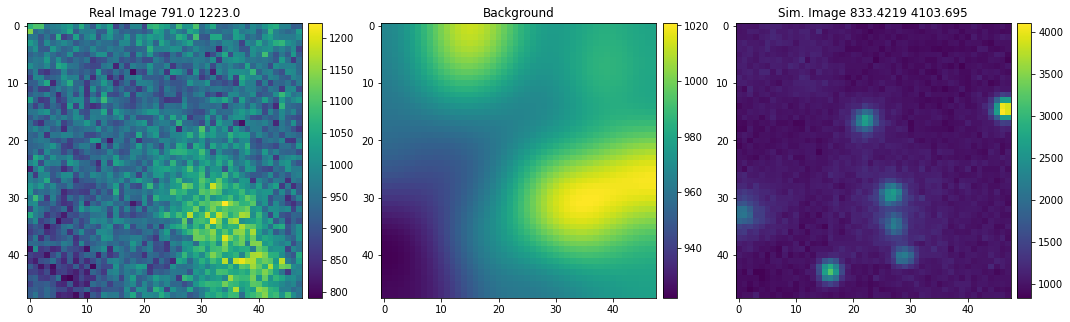

In [ ]:
from decode_fish.funcs.visualization import get_simulation_statistics
get_simulation_statistics(decode_dl, micro)

In [ ]:
inp_offset, inp_scale = get_forward_scaling(img_3d)
model = hydra.utils.instantiate(cfg.model, inp_scale=float(inp_scale), inp_offset=float(inp_offset))

psf  .to('cuda')
model.to('cuda')
micro.to('cuda')

Microscope(
  (noise): sCMOS()
)

In [ ]:
opt_sl = AdamW(model.parameters(), lr=cfg.supervised.lr)
scheduler_sl = torch.optim.lr_scheduler.StepLR(opt_sl, step_size=10000, gamma=0.5)

if cfg.evaluation is not None:
    eval_dict = dict(cfg.evaluation)
    eval_dict['crop_sl'] = eval(eval_dict['crop_sl'],{'__builtins__': None},{'s_': np.s_})
    eval_dict['px_size'] = list(eval_dict['px_size'])
else:
    eval_dict = None
    
save_dir = Path(cfg.output.save_dir)
save_dir.mkdir(exist_ok=True, parents=True)

OmegaConf.save(cfg, cfg.output.save_dir + '/train.yaml')

In [ ]:
point_process = PointProcessUniform(local_rate = torch.ones([2,1,48,48,48]).cuda()*.0001, min_int = 0.5)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

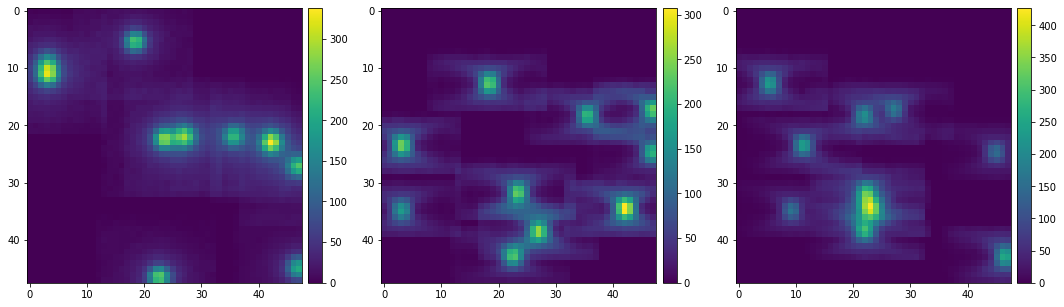

In [ ]:
xsim = micro(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)
plot_3d_projections(xsim[0,0])

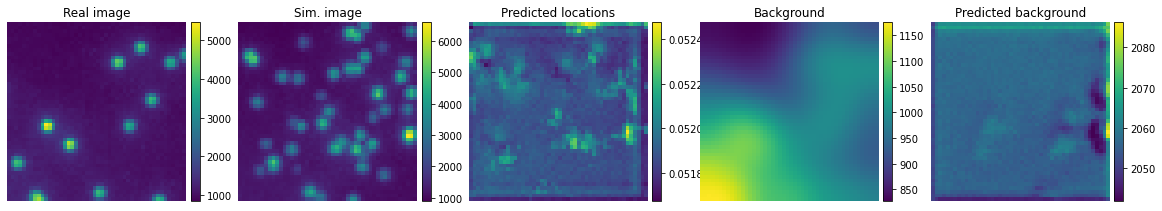

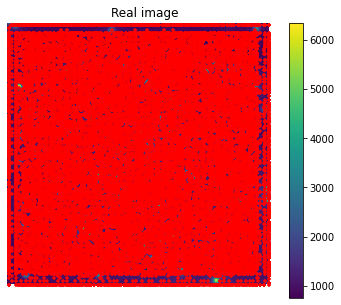

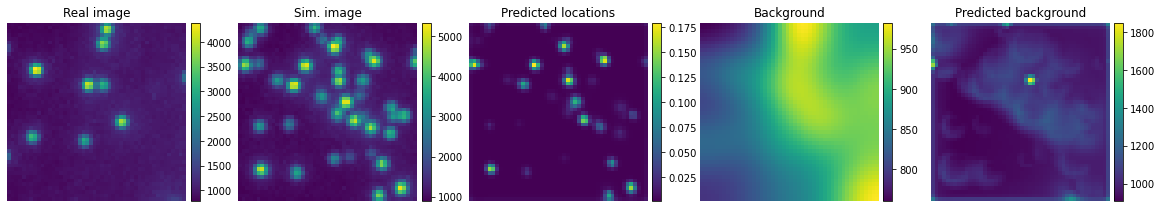

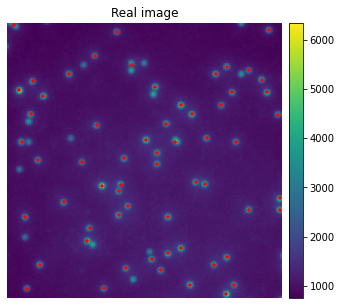

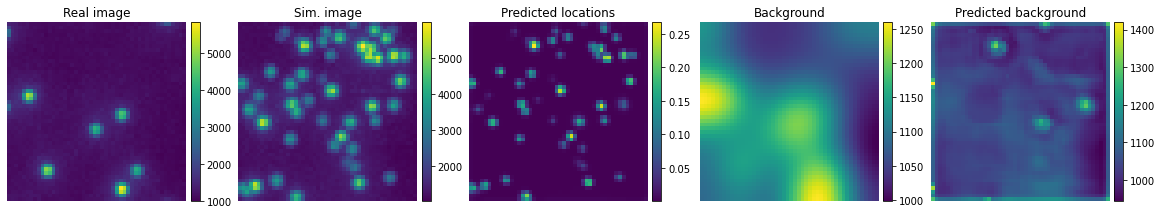

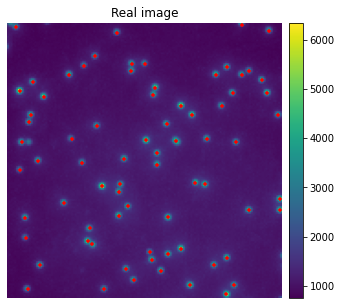

KeyboardInterrupt: 

In [ ]:
train_sl(model=model, 
         dl=decode_dl, 
         optim_net=opt_sl, 
         num_iter=10000,
         psf=psf,
         sched_net=scheduler_sl, 
         min_int=cfg.pointprocess.min_int, 
         microscope=micro, 
         log_interval=cfg.supervised.log_interval, 
         save_dir=cfg.output.save_dir,
         log_dir=cfg.output.log_dir,
         bl_loss_scale=cfg.supervised.bl_loss_scale,
         p_quantile=cfg.supervised.p_quantile,
         grad_clip=cfg.supervised.grad_clip,
         eval_dict=eval_dict)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train_sl.ipynb.
Converted 14_train_ae.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted index.ipynb.
